✅ Using Apple M1/M2 Metal Performance Shaders
Loading processed match sequences...
Found 2185 sequence files
Created 33423 training examples
Creating PyTorch dataset...


/var/folders/y7/49wy45ks7sv3890zpzvhdk1w0000gn/T/ipykernel_24960/2967340063.py:118: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.sequences = torch.FloatTensor(self.sequences)


Training samples: 23396
Validation samples: 5013
Test samples: 5014
Batch size: 64
Enhanced model initialized with input size: 13
Model parameters: 1,371,777


/Users/devadathks004/Desktop/dls-system/venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting enhanced training...
Epoch [1/100], Train Loss: 4559.0652, Val Loss: 3498.6649, RMSE: 59.15
Epoch [2/100], Train Loss: 1262.2230, Val Loss: 514.9568, RMSE: 22.69
Epoch [3/100], Train Loss: 545.6000, Val Loss: 438.2738, RMSE: 20.93
Epoch [5/100], Train Loss: 497.9857, Val Loss: 420.7780, RMSE: 20.51
Epoch [6/100], Train Loss: 491.2759, Val Loss: 423.9586, RMSE: 20.59
Epoch [7/100], Train Loss: 481.2424, Val Loss: 414.6292, RMSE: 20.36
Epoch [10/100], Train Loss: 475.6546, Val Loss: 405.8313, RMSE: 20.15
Epoch [11/100], Train Loss: 465.4703, Val Loss: 434.4234, RMSE: 20.84
Epoch [15/100], Train Loss: 451.0766, Val Loss: 401.7347, RMSE: 20.04
Epoch [16/100], Train Loss: 445.6060, Val Loss: 409.6757, RMSE: 20.24
Epoch [17/100], Train Loss: 428.0756, Val Loss: 382.1309, RMSE: 19.55
Epoch [18/100], Train Loss: 413.2171, Val Loss: 378.1402, RMSE: 19.45
Epoch [19/100], Train Loss: 395.8040, Val Loss: 364.4969, RMSE: 19.09
Epoch [20/100], Train Loss: 385.8451, Val Loss: 342.8157, RMSE:

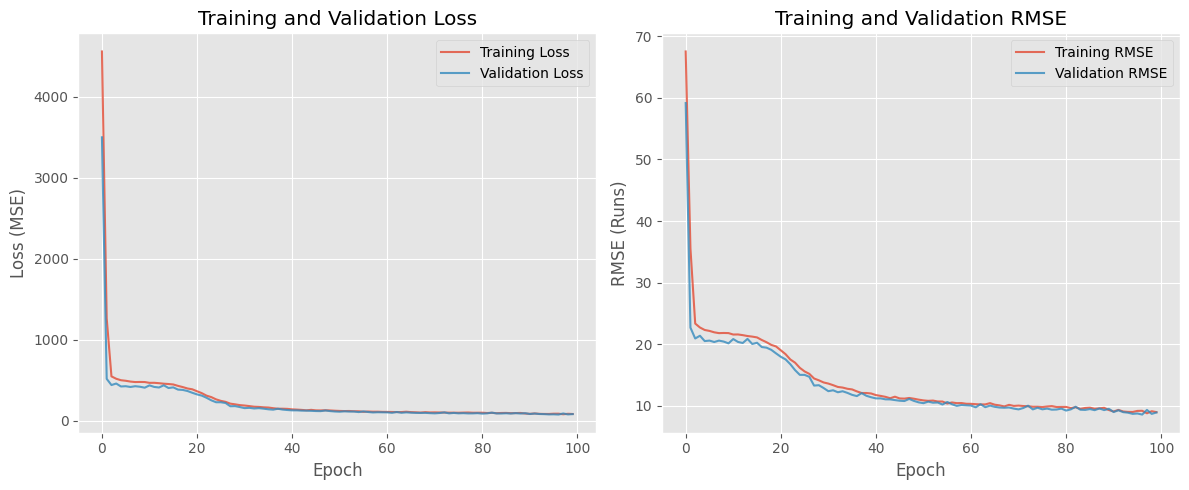


🎯 Enhanced Model Test Results:
RMSE: 7.69 runs
MAE: 4.31 runs
R² Score: 0.9660
Best Validation Loss: 73.6952


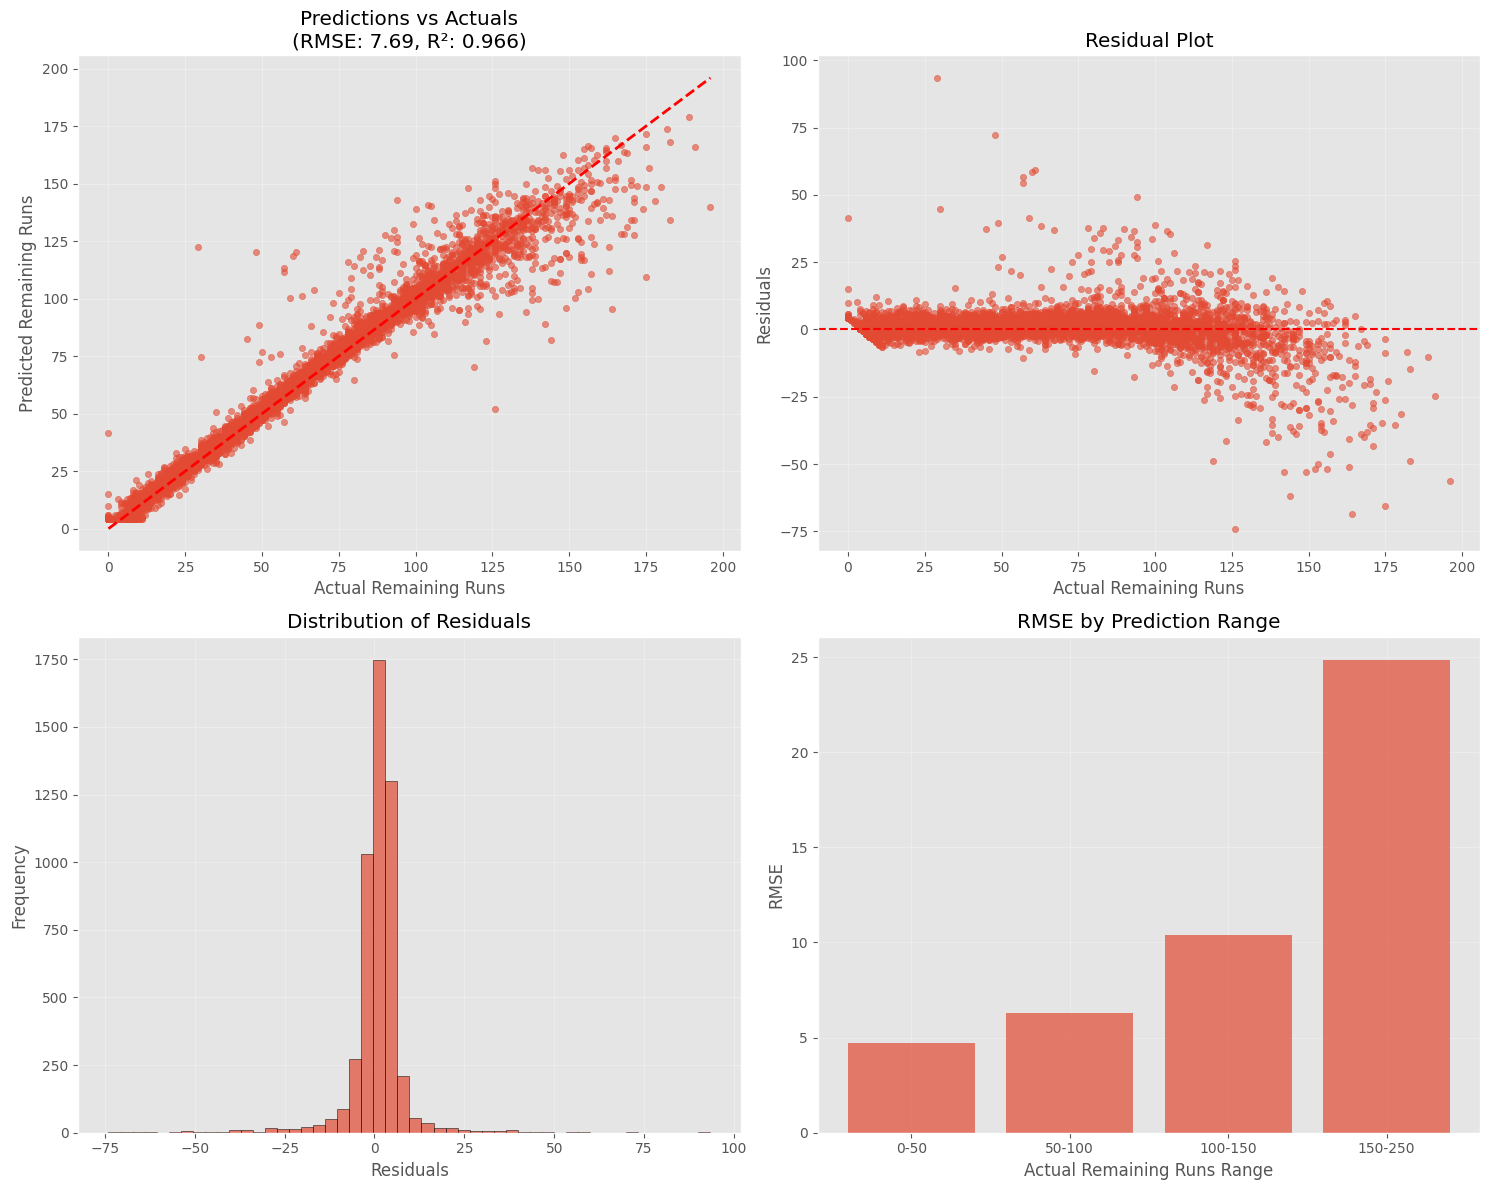


✅ Enhanced model training complete!
📁 Model saved as: ../data/processed/best_rnn_model_enhanced.pth
🚀 Ready for Step 3: Advanced Momentum Features!


In [ ]:
# 02_baseline_rnn_model_optimized.ipynb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import json
from glob import glob
import random

# ===== M1 OPTIMIZATIONS =====
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Optimize for M1 Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple M1/M2 Metal Performance Shaders")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (consider enabling MPS)")

#
torch.set_num_threads(8)  

%matplotlib inline
plt.style.use('ggplot')

print("Loading processed match sequences...")

# Step 1: Load the processed sequence data
def load_sequences_from_files(data_dir):
   
    sequence_files = glob(f"{data_dir}/*.csv")
    meta_files = glob(f"{data_dir}/*_meta.json")
    
    sequences = []
    targets = []
    metadata = []
    
    print(f"Found {len(sequence_files)} sequence files")
    
    for seq_file in sequence_files:
        try:
            df = pd.read_csv(seq_file)
        except:
            continue
        
       
        meta_file = seq_file.replace('.csv', '_meta.json')
        if os.path.exists(meta_file):
            with open(meta_file, 'r') as f:
                meta = json.load(f)
        else:
            continue
        
      
        if len(df) < 5:
            continue
        
        # For each sequence, create training examples
        # We'll predict remaining runs at each point in the match
        final_score = meta['final_score']
        
        for i in range(4, len(df)):  # Start from over 5 (index 4)
            # Input: sequence up to current over
            sequence = df.iloc[:i+1].values
            
            # Target: remaining runs to be scored
            current_score = df.iloc[i]['cumulative_runs']
            remaining_runs = final_score - current_score
            
            # Only add if remaining runs is non-negative and reasonable
            if 0 <= remaining_runs <= 200:  # Filter unrealistic values
                sequences.append(sequence)
                targets.append(remaining_runs)
                metadata.append(meta)
    
    print(f"Created {len(sequences)} training examples")
    return sequences, targets, metadata

# Load the data
sequences, targets, metadata = load_sequences_from_files('../data/processed/match_sequences')

# Step 2: Enhanced Dataset class with normalization
class CricketDataset(Dataset):
    def __init__(self, sequences, targets, max_length=20, normalize=True):
        self.sequences = []
        self.targets = []
        
        # Convert sequences to proper format
        for seq, target in zip(sequences, targets):
            # Pad or truncate sequences to max_length
            if len(seq) > max_length:
                seq = seq[-max_length:]  # Take last max_length overs
            else:
                # Pad with zeros at the beginning
                padding = np.zeros((max_length - len(seq), seq.shape[1]))
                seq = np.vstack([padding, seq])
            
            self.sequences.append(seq)
            self.targets.append(target)
        
        self.sequences = torch.FloatTensor(self.sequences)
        self.targets = torch.FloatTensor(self.targets)
        
        # Normalize features if requested
        if normalize:
            self.normalize_features()
    
    def normalize_features(self):
        """Normalize features to improve training stability"""
        # Calculate statistics across all sequences
        all_features = self.sequences.view(-1, self.sequences.shape[-1])
        self.feature_mean = all_features.mean(dim=0)
        self.feature_std = all_features.std(dim=0) + 1e-8  # Add small epsilon
        
        # Normalize
        self.sequences = (self.sequences - self.feature_mean) / self.feature_std
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Create dataset with optimizations
print("Creating PyTorch dataset...")
dataset = CricketDataset(sequences, targets, normalize=True)

# Split into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders with M1 optimization
batch_size = 64 if device.type == "mps" else 32  # Larger batch for MPS
num_workers = 0  # Set to 0 for MPS compatibility

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

# Step 3: Enhanced RNN Model with better architecture
class CricketRNN(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.3):
        super(CricketRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Enhanced LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=False  # Keep unidirectional for time series
        )
        
        # Enhanced fully connected layers with batch normalization
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.bn2 = nn.BatchNorm1d(hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Take the output from the last time step
        last_output = lstm_out[:, -1, :]
        
        # Pass through enhanced fully connected layers
        out = self.fc1(last_output)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        
        return out.squeeze()

# Initialize enhanced model
input_size = dataset.sequences.shape[2]  # Number of features
model = CricketRNN(input_size=input_size, hidden_size=256, num_layers=3, dropout=0.3)
model = model.to(device)

print(f"Enhanced model initialized with input size: {input_size}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Step 4: Enhanced training setup
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW is often better
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.5, verbose=True)

# Add gradient clipping for stability
max_grad_norm = 1.0

# Step 5: Enhanced training function with early stopping
def train_model(model, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 15
    
    print("Starting enhanced training...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping and model saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss,
                'feature_mean': dataset.feature_mean,
                'feature_std': dataset.feature_std
            }, '../data/processed/best_rnn_model_enhanced.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0 or patience_counter == 0:
            rmse = np.sqrt(avg_val_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, RMSE: {rmse:.2f}')
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return train_losses, val_losses

# Step 6: Train the enhanced model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=100)

# Step 7: Enhanced visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot([np.sqrt(loss) for loss in train_losses], label='Training RMSE', alpha=0.8)
plt.plot([np.sqrt(loss) for loss in val_losses], label='Validation RMSE', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('RMSE (Runs)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 8: Enhanced evaluation
def evaluate_model(model, test_loader, dataset):
    # Load best model
    checkpoint = torch.load('../data/processed/best_rnn_model_enhanced.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    
    # Calculate R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    print(f"\n🎯 Enhanced Model Test Results:")
    print(f"RMSE: {rmse:.2f} runs")
    print(f"MAE: {mae:.2f} runs") 
    print(f"R² Score: {r2:.4f}")
    print(f"Best Validation Loss: {checkpoint['best_val_loss']:.4f}")
    
    return predictions, actuals, rmse, mae, r2

# Evaluate the enhanced model
predictions, actuals, rmse, mae, r2 = evaluate_model(model, test_loader, dataset)

# Enhanced visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Predictions vs Actuals
axes[0,0].scatter(actuals, predictions, alpha=0.6, s=20)
axes[0,0].plot([0, max(actuals)], [0, max(actuals)], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Remaining Runs')
axes[0,0].set_ylabel('Predicted Remaining Runs')
axes[0,0].set_title(f'Predictions vs Actuals\n(RMSE: {rmse:.2f}, R²: {r2:.3f})')
axes[0,0].grid(True, alpha=0.3)

# Residuals plot
residuals = predictions - actuals
axes[0,1].scatter(actuals, residuals, alpha=0.6, s=20)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Actual Remaining Runs')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residual Plot')
axes[0,1].grid(True, alpha=0.3)

# Distribution of residuals
axes[1,0].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Residuals')
axes[1,0].grid(True, alpha=0.3)

# Error by prediction range
error_ranges = []
rmse_by_range = []
ranges = [(0, 50), (50, 100), (100, 150), (150, 250)]

for low, high in ranges:
    mask = (actuals >= low) & (actuals < high)
    if np.sum(mask) > 0:
        range_rmse = np.sqrt(np.mean((predictions[mask] - actuals[mask])**2))
        error_ranges.append(f"{low}-{high}")
        rmse_by_range.append(range_rmse)

axes[1,1].bar(error_ranges, rmse_by_range, alpha=0.7)
axes[1,1].set_xlabel('Actual Remaining Runs Range')
axes[1,1].set_ylabel('RMSE')
axes[1,1].set_title('RMSE by Prediction Range')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Enhanced model training complete!")
print(f"📁 Model saved as: ../data/processed/best_rnn_model_enhanced.pth")
print(f"🚀 Ready for Step 3: Advanced Momentum Features!")